**Model 1: PCNet (P_hat from H)**

Sum Rate Maximization Under QoS Constraints (SRM-QC)

In [2]:
## Reference
# F. Liang, C. Shen, W. Yu, and F. Wu, “Towards optimal power control via
# ensembling deep neural networks,” IEEE Transactions on Communications, vol. 68,
# no. 3, pp. 1760–1776, 2020, doi: https://doi.org/10.1109/TCOMM.2019.2957482.

In [3]:
# K = 5   # Number of transmitter-receiver pairs

In [4]:
# import numpy as np

# ## Function to generate an array of float values within a given range
# def generate_f_val(f_val_min, f_val_max, f_count):
#   f_val = []
#   for i in range(f_count):
#     f_val_temp = round(np.random.uniform(f_val_min, f_val_max),3)
#     f_val.append(f_val_temp)
#   return f_val

In [5]:
# ## Variances for noise signals
# # https://www.youtube.com/watch?v=OA4viERrlzA&list=PLTv48TzNRhaKz0C-dCAwimXSypV_5UTxg
# # From 6:44 to 0:55
# # Power Spectral Density of Noise, N0 = 1e-14.4 W/Hz at room temperature
# # If Bandwidth, B = 10 MHz
# # Then the Noise Power or Noise Variance = N0 X B = 1e-7.4 W 

# # sigma_sqr_noise = generate_f_val(1.1e-2, 1.9e-2, K)
# sigma_sqr_noise = generate_f_val(1, 1, K)
# print(sigma_sqr_noise)

In [6]:
# ## Minimum rate for the achievable SINR of multiple concurrent transmissions
# # SINR_P_min = generate_f_val(0.301, 0.305, K)
# SINR_P_min = generate_f_val(0.5, 0.5, K)
# print(SINR_P_min)

In [7]:
# ## Replacing SINR with SINR = 0 for some receiver(s)
# indx_zero = np.array([3, 4])
# for i in range(len(indx_zero)):
#   SINR_P_min[indx_zero[i]] = 0
# print(SINR_P_min)

In [8]:
# ## Maximum power allowed for transmission

# ## https://www.fcc.gov/general/radio-frequency-safety-0#:~:text=The%20SAR%20is%20a%20value,(1.6%20W%2Fkg).
# ## Cellular Telephone Specific Absorption Rate (SAR)
# # The SAR is a value that corresponds to the relative amount of RF energy 
# # absorbed in the head of a user of a wireless handset. The FCC limit for public
# # exposure from cellular telephones is an SAR level of 1.6 watts per kilogram.

# ## https://www.wilsonamplifiers.com/blog/how-to-read-cell-phone-signal-strength-the-right-way/
# ## What’s a Good Signal Strength for a Cell Phone?
# # -50 to -79 dBm: considered a great signal
# # -80 to -89 dBm: Considered good signal
# # -90 to -99 dBm: Considered average signal
# # -100 to -109 dBm: Considered poor signal
# # -110 to -120 dBm: Considered very poor signal

# ## https://www.rapidtables.com/convert/power/dBm_to_Watt.html 
# # -50 dBm = 1e-8 watt
# # decibel of mW (dBm) = 10 log10(Signal Power / 1 mW)

# ## https://www.youtube.com/watch?v=OA4viERrlzA&list=PLTv48TzNRhaKz0C-dCAwimXSypV_5UTxg
# # From 0:28 to 0:55
# # Transmit power may start at 1 mW for Bluetooth
# # 10 mW to 100 mW for mobile phones (Pmax = 100 MW, quite typical)
# # BTS can use up to 40 W

# # p_max = 1.0

In [9]:
import numpy as np

## Number of transmitter-receiver pairs
K = 5

## Variances for noise signals
sigma_sqr_noise = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype = float)
# sigma_sqr_noise = np.array([0.1, 0.1, 0.1, 0.1, 0.1], dtype = float)
# sigma_sqr_noise = np.array([0.01, 0.01, 0.01, 0.01, 0.01], dtype = float)
# sigma_sqr_noise = np.array([0.001, 0.001, 0.001, 0.001, 0.001], dtype = float)

## Minimum rate for the achievable SINR of multiple concurrent transmissions
SINR_P_min = np.array([0.5, 0.5, 0.5, 0, 0], dtype = float)

## Maximum transmit power
p_max = 1.0

In [10]:
## Function to generate the Circularly Symmetric Complex Gaussian (CSCG) distributions
def complex_gaussian(d_mean = 0, d_var = 1, n = 1000):
  # https://stackoverflow.com/questions/55700338/how-to-generate-a-complex-gaussian-white-noise-signal-in-pythonor-numpy-scipy
  # https://dsp.stackexchange.com/questions/40320/confusion-regarding-pdf-of-circularly-symmetric-complex-gaussian-rv
  # https://www.researchgate.net/post/When_is_Circular-symmetric_complex_Gaussian_channel_a_good_model
  # https://www.researchgate.net/post/How_can_I_generate_circularly_symmetric_complex_gaussian_CSCG_noise

  # Draw random samples from a normal (Gaussian) distribution.
  # Parameters:
  #   loc = Mean (“centre”) of the distribution.
  #   scale = Standard deviation (spread or “width”) of the distribution. Must be non-negative.
  #   size = int or tuple of ints, optional
  return np.random.normal(loc = d_mean, scale = np.sqrt(2*d_var)/2, size = (n, 2)).view(np.complex128)


## Function to generate the channel-coefficient matrix H
def generate_H(K, sigma_sqr_h, sample_size):
  hij = []
  for i in range(K):  # Total rows, i.e., total receivers or users
    hj =[]
    for j in range(K):  # Total columns, i.e., total transmitters
      h = complex_gaussian(d_mean = 0, d_var = sigma_sqr_h, n = sample_size)
      hj.append(h)
    hj = np.concatenate(hj, 1)
    hij.append(hj)
  hij = np.stack(hij, 1)
  return hij

In [11]:
## Create matrix H
H_size = int(1e6)
sigma_sqr_h = 1
H = generate_H(K, sigma_sqr_h, H_size)
print(H.shape)
# print(H)

(1000000, 5, 5)


In [12]:
import numba as nb

## Function to compute the square of the absolute value of an array of complex numbers
# https://stackoverflow.com/questions/30437947/most-memory-efficient-way-to-compute-abs2-of-complex-numpy-ndarray
# https://stackoverflow.com/questions/37197341/why-is-numba-throwing-an-error-regarding-numpy-methods-when-nopython-true
@nb.vectorize([nb.float64(nb.complex128),nb.float32(nb.complex64)])
def cmplx_abs_sqr(cmplx_var):
  return cmplx_var.real**2 + cmplx_var.imag**2

In [13]:
## Function to generate the matrix B
def generate_B(H_size, K, SINR_P_min, H):
  Bij_list = []
  H_abs_sqr = cmplx_abs_sqr(H)
  for k in range(H_size):
    for i in range(K):  # Total rows
      Bj_list =[]
      for j in range(K):  # Total columns
        if i==j:
          B = 0
        else:
          B_temp = np.multiply(SINR_P_min[i], H_abs_sqr[k,i,j])
          B = np.divide(B_temp, H_abs_sqr[k,i,i])
        Bj_list.append(B)
      Bij_list.append(Bj_list)
  Bij_array = np.array(Bij_list)
  Bij = Bij_array.reshape((H_size, K, K)) # H_size X row X column
  return Bij

In [14]:
## Create matrix B
B = generate_B(H_size, K, SINR_P_min, H)
print(B.shape)
# print(B)

(1000000, 5, 5)


In [15]:
## Function to generate the vector u
def generate_u(H_size, K, SINR_P_min, sigma_sqr_noise, H):
  ui_list = []
  H_abs_sqr = cmplx_abs_sqr(H)
  for k in range(H_size):
    for i in range(K):  # Total rows, i.e., total transmitters
      u_temp = np.multiply(SINR_P_min[i], sigma_sqr_noise[i])
      u = np.divide(u_temp, H_abs_sqr[k,i,i])
      ui_list.append(u)      
  ui_array = np.array(ui_list)
  ui = ui_array.reshape((H_size, K, 1)) # H_size X row X column
  return ui

In [16]:
## Create vector u
u = generate_u(H_size, K, SINR_P_min, sigma_sqr_noise, H)
print(u.shape)
# print(u)

(1000000, 5, 1)


In [17]:
## Finding indexes of H matrix with the hij set that satisfy constraint on the 
## maximum transmit power p_max

count_var = 0
indx_F_H = []
indx_temp_F_H = []
p_hat_temp_list = []

for k in range(H_size):
  eigen_value, eigen_vector = np.linalg.eig(B[k])
  # print(eigen_value)  
  if max(abs(eigen_value)) < 1:
    subtr = np.identity(K) - B[k,:,:]
    invr = np.linalg.inv(subtr)    
    u_temp = u[k]
    p_temp = np.matmul(invr, u_temp)
    p_hat_temp_list.append(p_temp)
    indx_temp_F_H.append(k)
    count_var += 1

p_hat_temp_array = np.array(p_hat_temp_list)
p_hat_temp = p_hat_temp_array.reshape((count_var,K,1))
print(p_hat_temp.shape)
# print(p_hat_temp)


P = abs(p_hat_temp)
fcount = 0
p_hat_list = []
for n in range(count_var):
  P_max = np.amax(P[n])
  if P_max <= p_max:
    p = p_hat_temp[n]
    p_hat_list.append(p)
    indx_F_H.append(indx_temp_F_H[n])
    fcount += 1

p_hat_array = np.array(p_hat_list)
p_hat = p_hat_array.reshape((fcount,K,1))
# p_hat = p_hat_array.reshape((fcount,1,K))
print(p_hat.shape)
p_hat_size = p_hat.shape[0]
# print(p_hat)

(320767, 5, 1)
(320767, 5, 1)


In [18]:
## H matrix for a feasible power profile
F_H_size = len(indx_F_H)
F_H = np.empty((F_H_size, K, K), dtype = complex, order = 'C')

for i in range(F_H_size):
  j = indx_F_H[i]
  F_H[i] = H[j]

print(F_H.shape)
# print(F_H)

(320767, 5, 5)


In [19]:
# ## Checking SINR_P for feasible H matrix
# F_H_abs_sqr = cmplx_abs_sqr(F_H)

# for k in range(F_H_size):
#   SINR_P_F_H_list = []
#   for i in range(K):
#     ph = 0
#     for j in range(K):
#       ph_j = np.multiply(p_hat[k,j], F_H_abs_sqr[k,i,j])
#       ph = ph + ph_j
    
#     numr = np.multiply(p_hat[k,i], F_H_abs_sqr[k,i,i])
#     dnumr = sigma_sqr_noise[i] + ph - numr
#     SINR_P_temp = np.divide(numr, dnumr)
#     SINR_P_F_H_list.append(SINR_P_temp)
  
#   SINR_P_F_H_array = np.array(SINR_P_F_H_list)
#   SINR_P_F_H = SINR_P_F_H_array.reshape((1, K))
#   print(SINR_P_F_H)
#   p_hat_t = p_hat[k].reshape((1, 1, K)) # H_size X row X column
#   print(p_hat_t)

In [20]:
# ## Saving 3D Numpy array to CSV file
# # Saving feasible H matrix F_H
# from numpy import savetxt

# # Reshaping the array from 3D to 2D
# F_H_2D = F_H.reshape(F_H.shape[0], -1)

# # Saving reshaped array to file in "Files" of colab at left bar
# # Can download the file in local drive
# savetxt('F_H_2D.csv', F_H_2D, delimiter=',')

In [21]:
# ## Saving p_hat matrix to CSV file
# # from numpy import savetxt

# # Reshaping the array from 3D to 2D
# p_hat_2D = p_hat.reshape(p_hat.shape[0], -1)

# # Saving reshaped array to file in "Files" of colab at left bar
# # Can download the file in local drive
# savetxt('p_hat_2D.csv', p_hat_2D, delimiter=',')

In [22]:
# ## Loading a NumPy array from a CSV file
# # https://neptune.ai/blog/google-colab-dealing-with-files
# # https://colab.research.google.com/drive/1TSF749i9-hoZv3n_8znjuf8Ei5o6YqL8
# # Loading F_H array from a CSV file
# from numpy import loadtxt

# ## Reading an array from the file
# # If we want to read a file from our local drive, we have to first upload it to Collab's session storage.
# F_H_2D_L = np.loadtxt('F_H_2D.csv', delimiter = ',', dtype = str)

# ## Reshaping the array from 2D to 3D
# # The initial declaration can be used to calculate the value of K
# # To get K from the CSV file:
# # K = int(np.sqrt(F_H_2D_L.shape[1]))
# F_H_3D = F_H_2D_L.reshape(F_H_2D_L.shape[0], F_H_2D_L.shape[1] // K, K)
# F_H_3D_size = F_H_3D.shape[0]

In [23]:
# ## Converting string data to complex data and removing the initial whitespace
# F_H_list = []
# for k in range(F_H_3D_size):
#   for i in range(K):  # Total rows
#     for j in range(K):  # Total columns
#       F_H_temp = complex(F_H_3D[k][i][j].strip())
#       F_H_list.append(F_H_temp)
# F_H_array = np.array(F_H_list)
# F_H = F_H_array.reshape((F_H_3D_size, K, K)) # H_size X row X column_count
# print(F_H.shape)
# F_H_size = F_H.shape[0]
# # print(F_H)

In [24]:
# ## Loading p_hat array from a CSV file
# # from numpy import loadtxt

# ## Reading an array from the file
# # If we want to read a file from our local drive, we have to first upload it to Collab's session storage.
# p_hat_2D_L = np.loadtxt('p_hat_2D.csv', delimiter = ',', dtype = float)

# ## Reshaping the array from 2D to 3D
# # The initial declaration can be used to calculate the value of K
# # To get K from the CSV file:
# # K = int(np.sqrt(F_H_2D_L.shape[1]))
# p_hat = p_hat_2D_L.reshape((p_hat_2D_L.shape[0], p_hat_2D_L.shape[1], 1)) # H_size X row X column
# p_hat_size = p_hat.shape[0]
# print(p_hat.shape)

In [25]:
## Function to split datasets for training, validation, and testing.
def split(np_array):
  data_size = np_array.shape[0]
  train_data_size = int(data_size * 0.8)
  valid_data_size = int(data_size * 0.1)
  test_data_size = int(data_size * 0.1)

  # train_data_size = int(206000)
  # valid_data_size = int(25000)
  # test_data_size = int(25000)

  train_e_indx = train_data_size
  valid_e_indx = train_e_indx + valid_data_size
  test_e_indx = valid_e_indx + test_data_size - 2
  # test_e_indx = valid_e_indx + test_data_size
  test_data_size_n = test_e_indx - valid_e_indx

  row_count = np_array.shape[1]
  column_count = np_array.shape[2]

  train_data = np.empty((train_data_size, row_count, column_count), dtype = complex, order = 'C')
  valid_data = np.empty((valid_data_size, row_count, column_count), dtype = complex, order = 'C')
  test_data = np.empty((test_data_size_n, row_count, column_count), dtype = complex, order = 'C')

  for i in range(train_e_indx):
    train_data[i] = np_array[i]
  
  xv = 0
  for j in range(train_e_indx, valid_e_indx):
    valid_data[xv] = np_array[j]
    xv = xv + 1
  
  xt = 0
  for k in range(valid_e_indx, test_e_indx):
    test_data[xt] = np_array[k]
    xt = xt + 1
  
  # print(train_data.shape, valid_data.shape, test_data.shape)

  
  ## Training input will be the absolute value
  train_input = np.absolute(train_data)
  valid_input = np.absolute(valid_data)
  test_input = np.absolute(test_data)

  print(train_input.shape, valid_input.shape, test_input.shape)

  return [train_input, valid_input, test_input, test_data]

In [26]:
## Split F_H Matrix
F_H_S = split(F_H)
train_input_F_H = F_H_S[0]
valid_input_F_H = F_H_S[1]
test_input_F_H = F_H_S[2]
test_data_F_H = F_H_S[3]

(256613, 5, 5) (32076, 5, 5) (32074, 5, 5)


In [27]:
# ## Split p_hat Matrix
# p_hat_S = split(p_hat)
# train_input_p_hat = p_hat_S[0]
# valid_input_p_hat = p_hat_S[1]
# test_input_p_hat = p_hat_S[2]
# test_data_p_hat = p_hat_S[3]

In [50]:
## Define the DNN model - The Sequential model
import tensorflow as tf
from tensorflow import keras
## from tensorflow.keras import layers # shows warning
from keras.api._v2.keras import layers

model = keras.Sequential(name = "sequential_model")

model.add(keras.Input(shape = (K,K), name = "hij_inputs"))
model.add(layers.Flatten(name = "flatten_layer_hij"))

model.add(layers.Dense(units = 2*K*K, activation = 'relu', input_shape = (K*K,), name = "dense_layer_1"))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units = K*K, activation = 'relu', input_shape = (2*K*K,), name = "dense_layer_2"))
model.add(layers.BatchNormalization())

model.add(layers.Dense(units = K, activation = 'sigmoid', input_shape = (K*K,), name = "P_hat"))

model.summary()

Model: "sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer_hij (Flatten)  (None, 25)               0         
                                                                 
 dense_layer_1 (Dense)       (None, 50)                1300      
                                                                 
 batch_normalization_6 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_layer_2 (Dense)       (None, 25)                1275      
                                                                 
 batch_normalization_7 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 P_hat (Dense)               (None, 5)            

In [29]:
# # https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
# # from tensorflow.keras import backend as bk
# from keras.api._v2.keras import backend

# print(model.inputs)
# print(model.outputs)
# model.layers[3].output

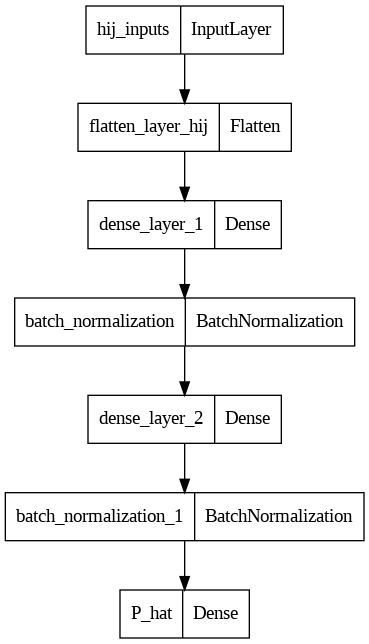

In [30]:
## Plot the model as a graph
keras.utils.plot_model(model, "Sequential_Model.png")

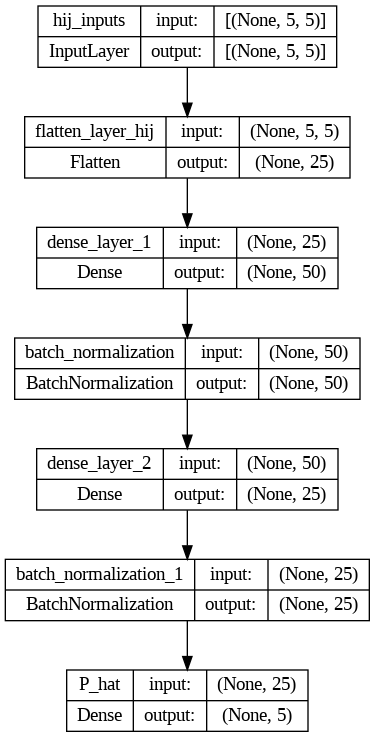

In [31]:
## Display the input and output shapes of each layer
keras.utils.plot_model(model, "Sequential_Model_with_shape_info.png", show_shapes=True)

In [32]:
## Convert sigma_sqr_noise from numpy array to tensor
sigma_sqr_noise_t = tf.convert_to_tensor(sigma_sqr_noise, dtype = float)
tf.print(sigma_sqr_noise_t)

[0 0 0 0 0]


In [33]:
# ## The customized loss function
# def custom_loss(y_true, y_pred):
#   p = tf.math.multiply(p_max, y_pred)
#   hij = tf.reshape(y_true[:,0:K*K], (-1,K,K))
#   hij_abs_sqr = tf.math.square(tf.math.abs(hij))

#   R_P = 0.0
#   for i in range(K):  # Total rows
#     ph = 0.0
#     for j in range(K):  # Total columns
#       ph_j = tf.math.multiply(p[:,j], hij_abs_sqr[:,i,j])
#       ph = tf.math.add(ph, ph_j)
    
#     numr = tf.math.multiply(p[:,i], hij_abs_sqr[:,i,i])
#     dnumr = tf.math.add(sigma_sqr_noise_t[i], tf.math.subtract(ph, numr))
#     SINR_i = tf.math.divide(numr, dnumr)
#     R_P = tf.math.add(R_P, (tf.math.log(1 + SINR_i)/tf.math.log(2.0)))
  
#   loss = -R_P
#   loss = tf.reduce_mean(loss) # batch mean
#   return loss

In [34]:
## Convert SINR_P_min from numpy array to tensor
SINR_P_min_t = tf.convert_to_tensor(SINR_P_min, dtype = float)
tf.print(SINR_P_min_t)

[0.5 0.5 0.5 0 0]


In [35]:
## The customized loss function that penalizes the constraint violation
def custom_loss(y_true, y_pred):
  p = tf.math.multiply(p_max, y_pred)
  hij = tf.reshape(y_true[:,0:K*K], (-1,K,K))
  hij_abs_sqr = tf.math.square(tf.math.abs(hij))

  lambda_l = 10.0
  R_P = 0.0
  pnlty_f_CV = 0.0

  for i in range(K):  # Total rows
    ph = 0.0
    for j in range(K):  # Total columns
      ph_j = tf.math.multiply(p[:,j], hij_abs_sqr[:,i,j])
      ph = tf.math.add(ph, ph_j)
    
    numr = tf.math.multiply(p[:,i], hij_abs_sqr[:,i,i])
    dnumr = tf.math.add(sigma_sqr_noise_t[i], tf.math.subtract(ph, numr))
    SINR_i = tf.math.divide(numr, dnumr)
    R_P = tf.math.add(R_P, (tf.math.log(1 + SINR_i)/tf.math.log(2.0)))
    pnlty_f_CV = tf.math.add(pnlty_f_CV, (tf.math.log(1 + tf.nn.relu(SINR_P_min_t[i] - SINR_i))/tf.math.log(2.0)))
  
  loss = tf.math.add(-R_P, tf.math.multiply(lambda_l, pnlty_f_CV))
  loss = tf.reduce_mean(loss) # batch mean
  return loss

Epoch 1/250
257/257 [==============================] - 4s 7ms/step - loss: 4.5946 - val_loss: 3.8922
Epoch 2/250
257/257 [==============================] - 1s 5ms/step - loss: 4.4747 - val_loss: 4.2456
Epoch 3/250
257/257 [==============================] - 1s 5ms/step - loss: 4.3541 - val_loss: 4.2335
Epoch 4/250
257/257 [==============================] - 1s 5ms/step - loss: 4.2349 - val_loss: 4.1284
Epoch 5/250
257/257 [==============================] - 2s 6ms/step - loss: 4.1163 - val_loss: 4.0080
Epoch 6/250
257/257 [==============================] - 2s 6ms/step - loss: 3.9982 - val_loss: 3.8965
Epoch 7/250
257/257 [==============================] - 1s 5ms/step - loss: 3.8799 - val_loss: 3.7821
Epoch 8/250
257/257 [==============================] - 2s 7ms/step - loss: 3.7629 - val_loss: 3.6699
Epoch 9/250
257/257 [==============================] - 1s 5ms/step - loss: 3.6488 - val_loss: 3.5535
Epoch 10/250
257/257 [==============================] - 1s 5ms/step - loss: 3.5367 - val_lo

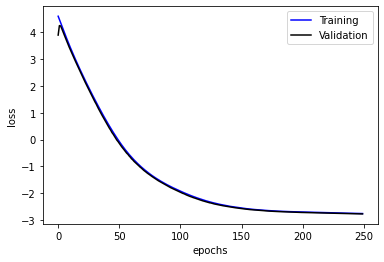

In [51]:
## Build and compile the DNN model
## Training and Testing
## https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
import matplotlib.pyplot as plt

optA = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model.compile(optimizer = optA, loss = custom_loss)

history = model.fit(train_input_F_H, train_input_F_H, epochs = 250, validation_data = (valid_input_F_H, valid_input_F_H), batch_size = 1000)

plt.plot(history.epoch, history.history['loss'], color = "blue", label = "Training")
plt.plot(history.epoch, history.history['val_loss'], color="black", label = "Validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [52]:
## Constraint violation probability and
## finding indexes of test_input_F_H matrix with the hij set that do not satisfy
## constraint on the minimum SINR_P_min rate but satisfy the maximum transmit
## power p_max

output_P_hat_temp = p_max * model.predict(test_input_F_H)
output_P_hat = output_P_hat_temp.reshape((output_P_hat_temp.shape[0], output_P_hat_temp.shape[1], 1)) # test_input_F_H_size X row X column
output_P_hat_size = output_P_hat.shape[0]
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H)

indx_n = []
count_v = 0

for k in range(output_P_hat_size):
  for i in range(K):  # Total rows
    ph = 0
    for j in range(K):  # Total columns
      ph_j = np.multiply(output_P_hat[k,j], test_data_F_H_abs_sqr[k,i,j])
      ph = ph + ph_j
    
    numr = np.multiply(output_P_hat[k,i], test_data_F_H_abs_sqr[k,i,i])
    dnumr = sigma_sqr_noise[i] + ph - numr
    SINR_out = np.divide(numr, dnumr)
    if np.round(SINR_out, decimals = 3) < SINR_P_min[i]:
      indx_n.append(k)
      count_v = count_v + 1
      # print(SINR_out)
      break

violation_prb = (count_v / output_P_hat_size) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))
# print(len(indx_n))
# print(indx_n)

1003/1003 [==============================] - 1s 1ms/step
Constraints Violation Probability: 27.50%


In [53]:
## Finding indexes of test_input_F_H matrix that satisfy constraints on both the 
## minimum SINR_P_min rate and the maximum transmit power Pmax
i = 0
indx_q = []

for k in range(output_P_hat_size):
  if k == indx_n[i]:
    i = i +1
    if  i == len(indx_n):
      i = i - 1
  else:
    indx_q.append(k)

print(len(indx_q))
# print(indx_q)

23255


In [54]:
## H of test_input_F_H matrix that satisfy both constraint on the minimum
## SINR_P_min rate and p_max
Q_H_size = len(indx_q)
Q_H = np.empty((Q_H_size, K, K), dtype = complex, order = 'C')

for i in range(Q_H_size):
  j = indx_q[i]
  Q_H[i] = test_input_F_H[j]

print(Q_H.shape)
# print(Q_H)

(23255, 5, 5)


In [55]:
##  P_Hat of output_P_hat matrix that satisfy both constraint on the minimum
## SINR_P_min rate and p_max
Q_P_Hat = np.empty((Q_H_size, K, 1), dtype = float, order = 'C')

for i in range(Q_H_size):
  j = indx_q[i]
  Q_P_Hat[i] = output_P_hat[j]

print(Q_P_Hat.shape)
# print(Q_P_Hat)

(23255, 5, 1)


In [56]:
## Function to calculate the average sum rate
# Here, p_model is the output of DNN, and it is a 2D array.
import math

def average_sum_rate(hij, p_model, sigma_sqr_noise, K):
  R = 0
  hij_size = hij.shape[0]
  hij_abs_sqr = cmplx_abs_sqr(hij)

  for k in range(hij_size):
    for i in range(K):  # Total rows
      phn = 0
      for j in range(K):  # Total columns
        phn_j = np.multiply(p_model[k,j], hij_abs_sqr[k,i,j])
        phn = phn + phn_j
      
      numr_s = np.multiply(p_model[k,i], hij_abs_sqr[k,i,i])
      dnumr_s = sigma_sqr_noise[i] + phn - numr_s
      R_temp = math.log2(1 + np.divide(numr_s, dnumr_s))
      R = R + R_temp
  
  return (R/hij_size)

In [57]:
## DNN Sum Rate for test_data_F_H
sumrate_F_H = average_sum_rate(test_data_F_H, output_P_hat, sigma_sqr_noise, K)
print("Average Sum Rate for all H matrices: {:.2f} Bit/Second/Hertz".format(sumrate_F_H))

Average Sum Rate for all H matrices: 3.04 Bit/Second/Hertz


In [58]:
## DNN Sum Rate for only Q_H
sumrate_Q_H = average_sum_rate(Q_H, Q_P_Hat, sigma_sqr_noise, K)
print("Average Sum Rate for desired H matrices only: {:.2f} Bit/Second/Hertz".format(sumrate_Q_H))

Average Sum Rate for desired H matrices only: 3.31 Bit/Second/Hertz
